In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

In [3]:
dir_path = r'E:\python_projects\notebooks\timeseries\1._Лекция_tsml\Series'
filenames = os.listdir(dir_path)
dfs = {f'{file[0:-4]}_df'.replace('-','_'): pd.read_csv(dir_path+'\\'+file, parse_dates=True, index_col=0) for file in filenames}
for key, df in dfs.items():
   globals()[key] = df

dfs.keys()

C:\Users\Big Brother\AppData\Local\Temp\ipykernel_22236\939913729.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfs = {f'{file[0:-4]}_df'.replace('-','_'): pd.read_csv(dir_path+'\\'+file, parse_dates=True, index_col=0) for file in filenames}


dict_keys(['daily_total_female_births_in_cal_df', 'international_airline_passengers_df', 'mean_monthly_air_temperature_deg_df', 'monthly_boston_armed_robberies_j_df', 'monthly_sales_of_company_x_jan_6_df', 'weekly_closings_of_the_dowjones__df'])

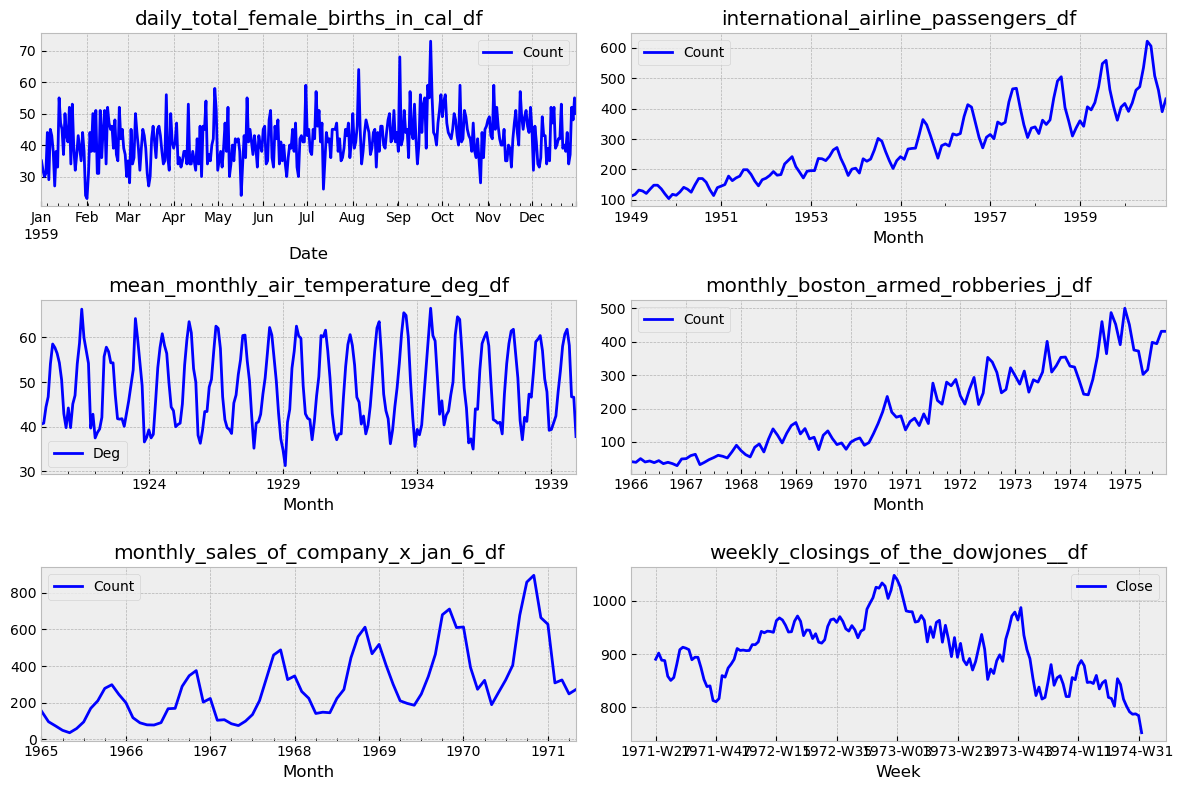

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    layout = (3, 2)
    for i, key in enumerate(dfs.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        dfs[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [5]:
female_births = dfs['daily_total_female_births_in_cal_df']
air_temp = dfs['mean_monthly_air_temperature_deg_df']

In [6]:
def Dickey_Fuller(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return  dfoutput

def kpss_test(timeseries, regression='c'):
    
    dftest = kpss(timeseries, regression=regression)
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for [key, value] in dftest[3].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

def tsplot(y, df_name, lags=None, figsize=(10, 8), style='bmh'):

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(df_name)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return


In [7]:
print(Dickey_Fuller(female_births), '\n', '*'*40, '\n', kpss_test(female_births))

Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64 
 **************************************** 
 Test Statistic           1.612966
p-value                  0.010000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\Big Brother\AppData\Local\Temp\ipykernel_22236\3943163443.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  dftest = kpss(timeseries, regression=regression)


In [8]:
print(Dickey_Fuller(air_temp), '\n', '*'*40, '\n', kpss_test(air_temp))

Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64 
 **************************************** 
 Test Statistic           0.04386
p-value                  0.10000
Lags Used                6.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


C:\Users\Big Brother\AppData\Local\Temp\ipykernel_22236\3943163443.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  dftest = kpss(timeseries, regression=regression)


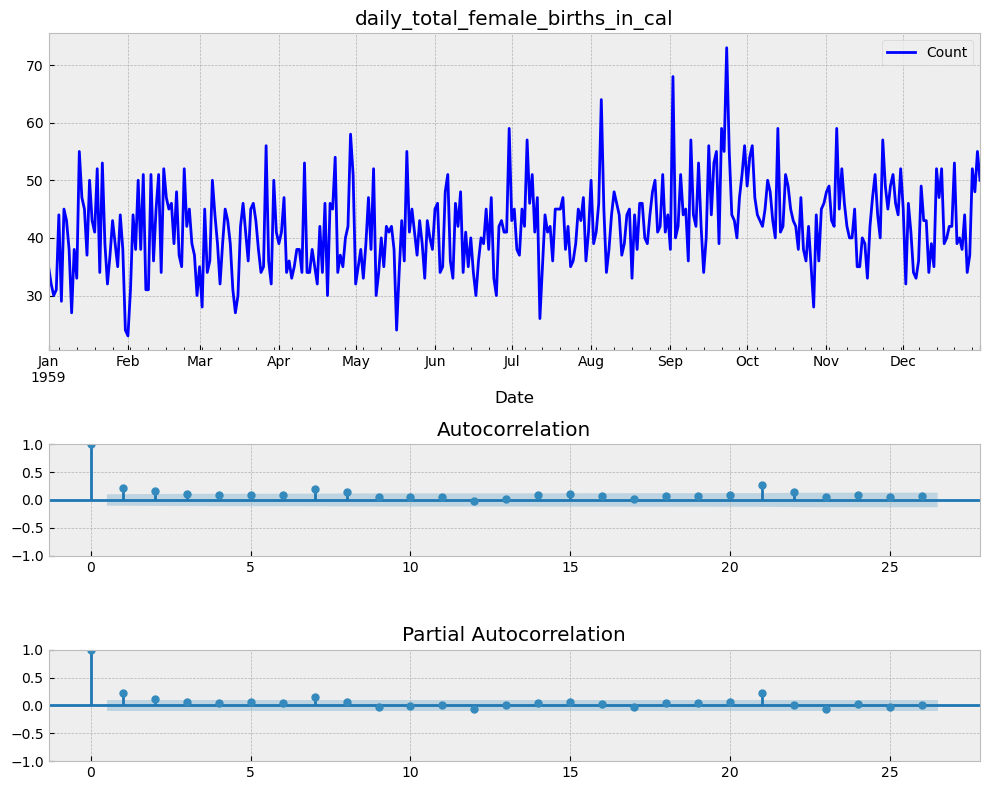

In [9]:
tsplot(female_births, 'daily_total_female_births_in_cal')

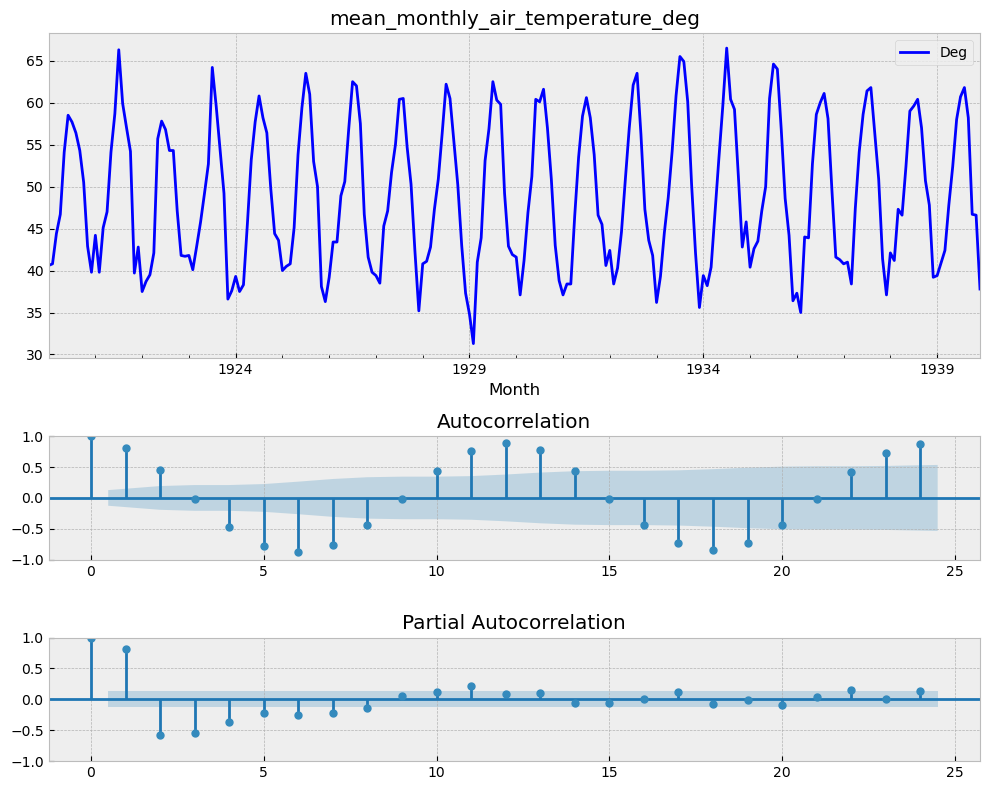

In [11]:
tsplot(air_temp, 'mean_monthly_air_temperature_deg')

Тест KPSS для первого ряда говорит о его нестационарности. Есть смысл его диффиренцировать

Test Statistic             0.187388
p-value                    0.100000
Lags Used                136.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


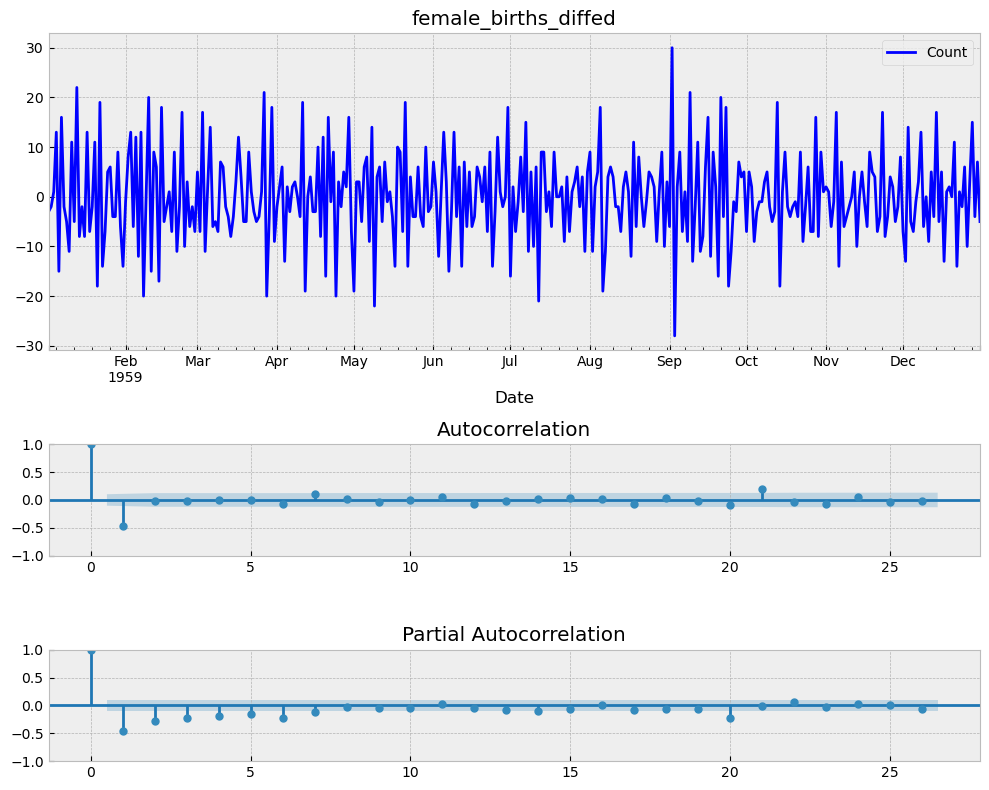

In [132]:
female_births_diffed = female_births.diff()
female_births_diffed = female_births_diffed.iloc[1:]
print(kpss_test(female_births_diffed))
tsplot(female_births_diffed, 'female_births_diffed')

Теперь ряд можно считать стационарным

In [228]:
def ts_split_generator(df, n_splits = 5, test_size = 30):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    ts = pd.Series(df.iloc[:, 0])
    for train_index, test_index in tscv.split(ts):
        train, test = ts[train_index], ts[test_index]
        yield train, test

def ema(df, trend = None, seasonal = None, seasonal_periods = None, method = 'Powell', n_splits = 5):

    train_errors = []
    test_errors = []
    all_train = []
    all_train_predictions = []
    all_test = []
    all_test_predictions = []

    splitter = ts_split_generator(df, n_splits = n_splits)

    for train, test in splitter:
        model = ES(train, 
                   trend=trend, 
                   seasonal=seasonal, 
                   seasonal_periods=seasonal_periods,
                   initialization_method = 'heuristic'
                   )
                
        fitted_model = model.fit(optimized=True, method = method)
        train_predictions = fitted_model.predict(start=train.index[0], end=train.index[-1])
        test_predictions = fitted_model.forecast(len(test))
        

        train_errors.append(np.mean((train - train_predictions) ** 2))
        test_errors.append(np.mean((test - test_predictions) ** 2))

        all_train.append(train)
        all_train_predictions.append(train_predictions)
        all_test.append(test)
        all_test_predictions.append(test_predictions)

    train_mean_mse = np.mean(train_errors)
    test_mean_mse = np.mean(test_errors)

    return train_predictions, test, test_predictions, train_mean_mse, test_mean_mse

In [221]:
def plot_draw(original_ts, train_predictions, test_predictions, train_mean_mse, test_mean_mse, ts_name):

    fig, (ax0) = plt.subplots(1, 1, figsize = (15, 5))
    ax0.grid(color = 'grey', alpha = 0.7, label = 'Inline Label')
    original_зplot = ax0.plot(original_ts, label = ts_name)
    train_plot = ax0.plot(train_predictions, label = f'train predictions. train mse: {train_mean_mse}', color = 'green')
    test_predictions_plot = ax0.plot(test_predictions, label = f'test predictions. test mse: {test_mean_mse}', color = 'red')
    ax0.legend(loc = 'lower right')
    plt.show()
    plt.close()
    return

'basinhopping', 'bh', 'least_squares', 'ls', 'L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr'

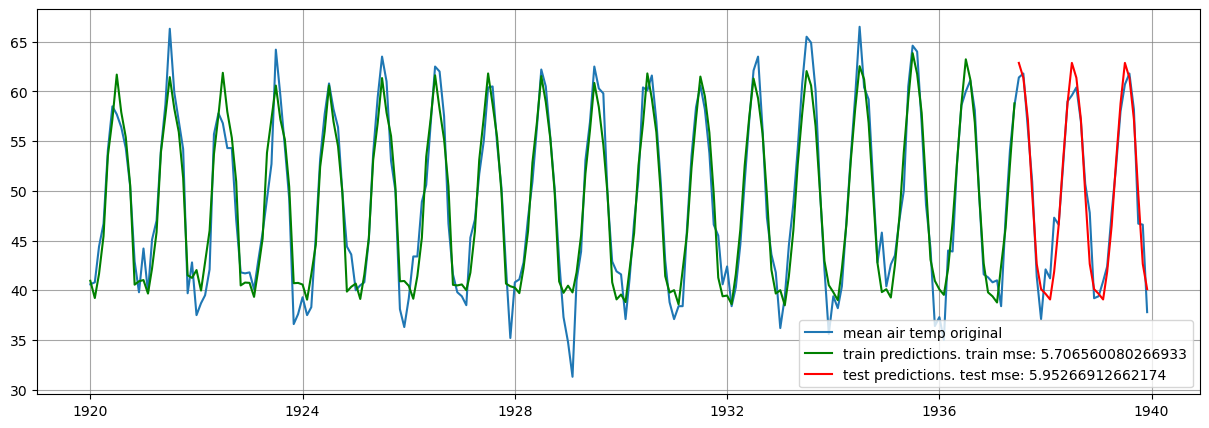

In [236]:
a_train_predictions, a_test, a_test_predictions, a_train_mean_mse, a_test_mean_mse = ema(air_temp, seasonal = 'mul', seasonal_periods = 12, method = 'basinhopping')
plot_draw(air_temp, a_train_predictions, a_test_predictions, a_train_mean_mse, a_test_mean_mse, 'mean air temp original')

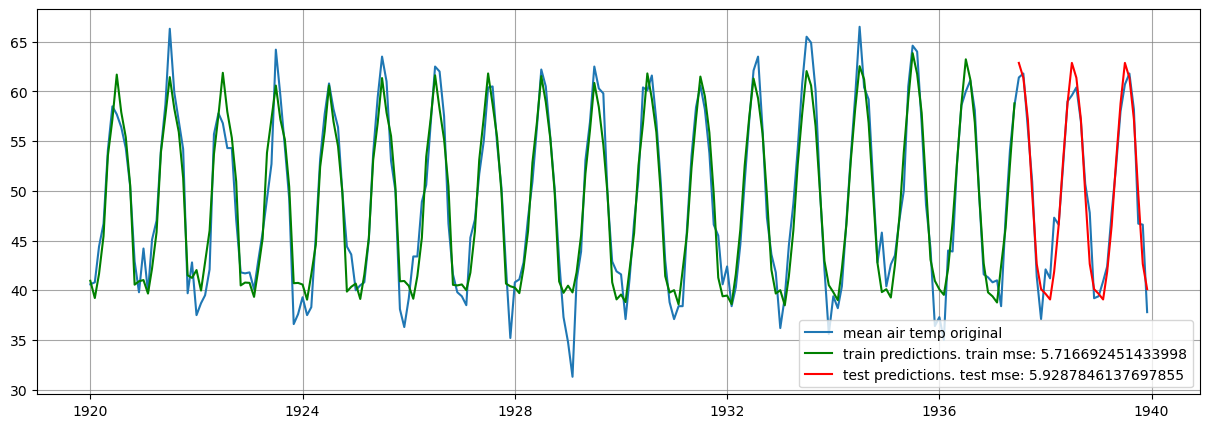

In [243]:
a_train_predictions, a_test, a_test_predictions, a_train_mean_mse, a_test_mean_mse = ema(air_temp, seasonal = 'mul', seasonal_periods = 12, method = 'trust-constr')
plot_draw(air_temp, a_train_predictions, a_test_predictions, a_train_mean_mse, a_test_mean_mse, 'mean air temp original')

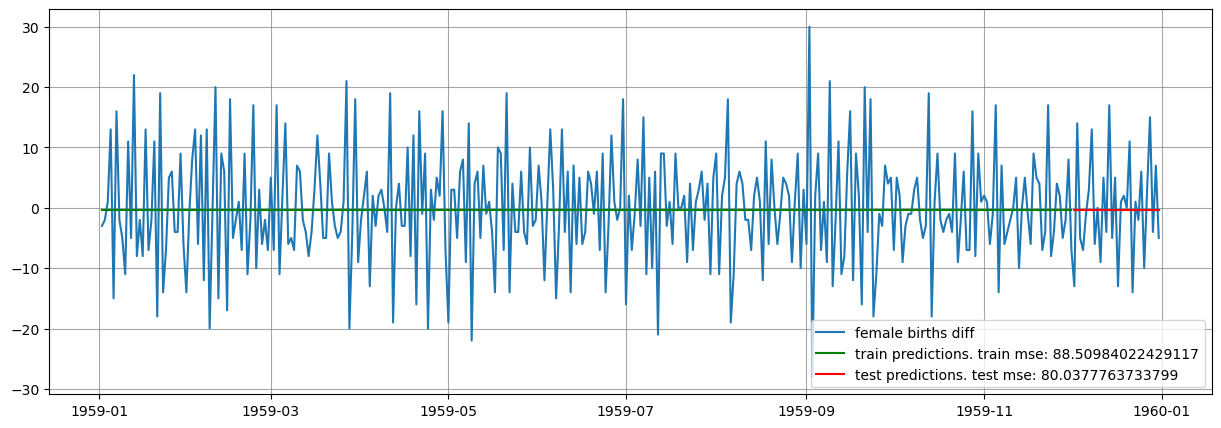

In [245]:
f_train_predictions, f_test, f_test_predictions, f_train_mean_mse, f_test_mean_mse = ema(female_births_diffed, None, None)
plot_draw(female_births_diffed, f_train_predictions, f_test_predictions, f_train_mean_mse, f_test_mean_mse, 'female births diff')

Насколько я понимаю, стационарные ряда ряды бесполезно пытаться предсказывать при помощи простых моделей скользящего среднего, поскольку прогнозы модели быдут близкими к среднему значению ряда

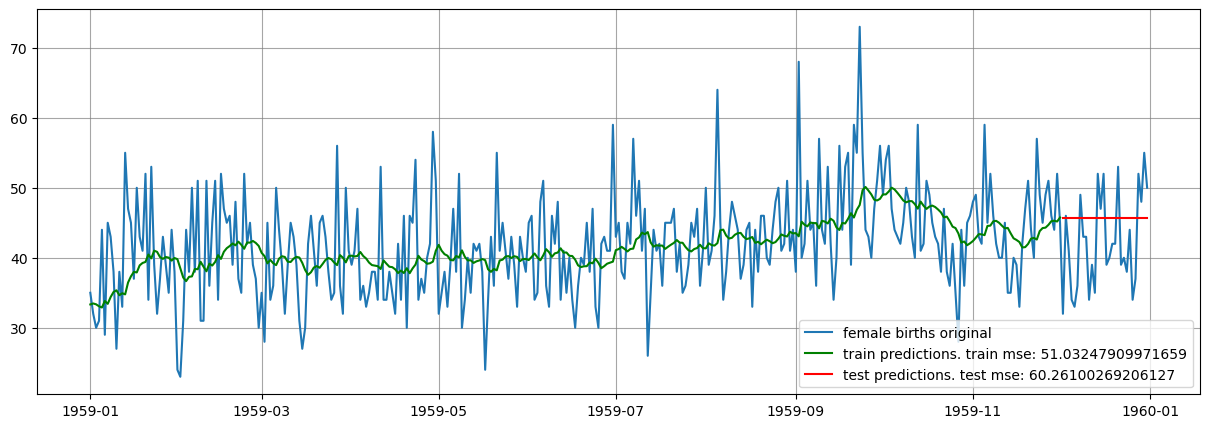

In [247]:
f_train_predictions, f_test, f_test_predictions, f_train_mean_mse, f_test_mean_mse = ema(female_births, None, None, method = 'L-BFGS-B')
plot_draw(female_births, f_train_predictions, f_test_predictions, f_train_mean_mse, f_test_mean_mse, 'female births original')

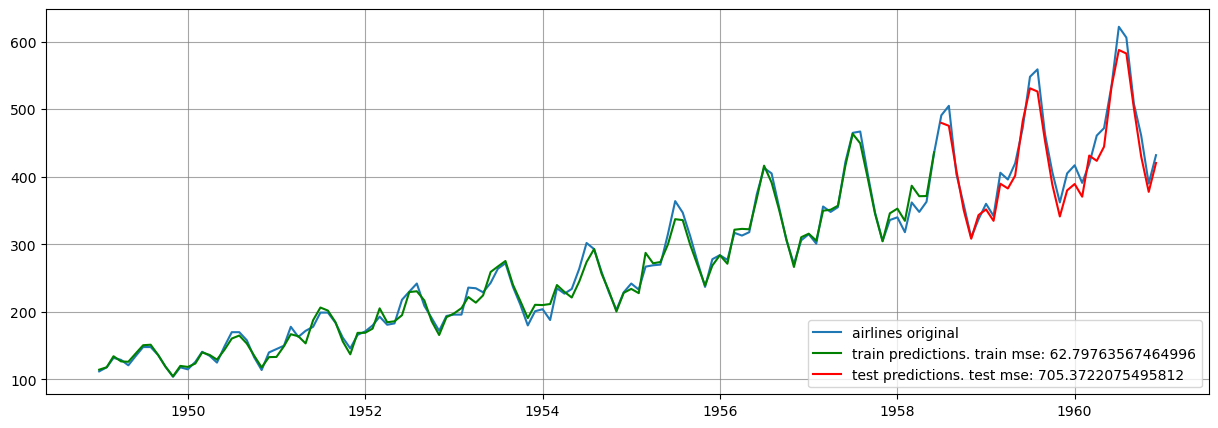

In [249]:
airLines = dfs['international_airline_passengers_df']

al_train_predictions, al_test, al_test_predictions, al_train_mean_mse, al_test_mean_mse = ema(airLines, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, n_splits = 3, method = 'basinhopping')
plot_draw(airLines, al_train_predictions, al_test_predictions, al_train_mean_mse, al_test_mean_mse, 'airlines original')